In [1]:
import torch
from torch_geometric.datasets import Planetoid, KarateClub
import copy
from torch_geometric.utils import to_scipy_sparse_matrix, negative_sampling, to_dense_adj, to_networkx
from MPNN import MyGCN
from NCNC import NCNC
from torch import nn
from utils import split_in_half, TargetLinkRemoval, MyPreTransform, predictionwithLogit, Union, confusion_matrix, draw_hist
import shutil
import os
import gc
import time
from matplotlib import pyplot as plt
import sys
import networkx as nx

In [2]:
%env CUDA_LAUNCH_BLOCKING=1
!nvidia-smi
print(torch.version.cuda)  # 检查 CUDA 版本
print(torch.backends.cudnn.enabled)  # 检查 cuDNN 是否可用
print(torch.cuda.is_available())  # 检查 CUDA 是否可用
print(sys.executable)
torch.cuda.empty_cache()
torch.cuda.init()

env: CUDA_LAUNCH_BLOCKING=1
Wed Jun 12 12:47:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off | 00000000:3B:00.0 Off |                  N/A |
| 39%   27C    P8              11W / 250W |      2MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------------------------------

torch.Size([2, 10556])
torch.Size([2, 8445])
tensor([[   0,    0,    7,  ..., 2699, 2706, 2706],
        [ 633, 1862,  208,  ..., 2630, 1473, 2707]])


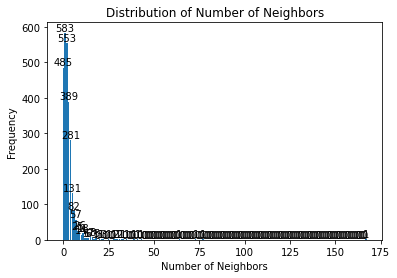

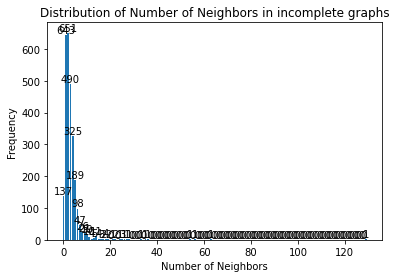

In [3]:


#dataset = Planetoid(root='/dataset', name='cora',pre_transform=None,force_reload=True)
dataset = Planetoid(root = 'dataset', name='Cora',transform=None)
#dataset = KarateClub(transform = None)
print(dataset[0].edge_index.shape)

ratio = 0.8
my_pre_transform = MyPreTransform(ratio)
removed_dataset = [my_pre_transform(dataset[0])]
#removed_dataset = Planetoid(root='dataset', name='Cora', transform=my_pre_transform)
removed_edges = my_pre_transform.removed
#removed_dataset = KarateClub(transform = my_pre_transform)
print(removed_dataset[0].edge_index.shape)
print(removed_edges)

#original_adjacent = to_scipy_sparse_matrix(dataset[0].edge_index, num_nodes=dataset[0].num_nodes)
#removed_adjacent = to_scipy_sparse_matrix(removed_dataset[0].edge_index, num_nodes=removed_dataset[0].num_nodes)
features = removed_dataset[0].x

draw_hist(dataset,title = "Distribution of Number of Neighbors")
draw_hist(removed_dataset,title = "Distribution of Number of Neighbors in incomplete graphs")



In [4]:
edges = dataset[0].edge_index
num_nodes = dataset[0].num_nodes
training_edges = removed_dataset[0].edge_index
total_samples = training_edges.shape[1]
num_pos_sample = 1000
num_neg_sample = 2*num_pos_sample
indices = torch.randperm(total_samples)
positive_samples = training_edges[:,indices]

#negative_samples = negative_sampling(edge_index=edges, num_nodes=dataset[0].num_nodes, num_neg_samples=num_neg_sample)

pos_labels = torch.ones(num_pos_sample)
neg_labels = torch.zeros(num_neg_sample)

firsthalf_pos_dataset, firsthalf_pos_label, secondhalf_pos_dataset, secondhalf_pos_label = split_in_half(positive_samples, pos_labels)
#firsthalf_neg_dataset, firsthalf_neg_label, secondhalf_neg_dataset, secondhalf_neg_label = split_in_half(negative_samples, neg_labels)
original_adjacent = to_dense_adj(edges, max_num_nodes = dataset[0].num_nodes)[0]
#trainingAdjacent = to_dense_adj(training_edges, max_num_nodes = removed_dataset[0].num_nodes)[0]
#original_adjacent = torch.sparse_coo_tensor(edges, torch.ones(edges.shape[1]), torch.Size([num_nodes, num_nodes]))
#trainingAdjacent = torch.sparse_coo_tensor(training_edges, torch.ones(training_edges.shape[1]), torch.Size([num_nodes, num_nodes]))

#print(trainingAdjacent.shape)

#firsthalf_pos_dataset = firsthalf_pos_dataset.to('cuda')
#trainingAdjacent = trainingAdjacent.to('cuda')
features = features.to('cuda')
#firsthalf_pos_label = firsthalf_pos_label.to('cuda')
#edges = edges.to('cuda')
#training_edges = training_edges.to('cuda')
#positive_samples = positive_samples.to('cuda')

'''
trainingSet = torch.cat((firsthalf_pos_dataset, firsthalf_neg_dataset), dim = 1)
train_labels = torch.cat((firsthalf_pos_label,firsthalf_neg_label))
testSet = torch.cat((secondhalf_pos_dataset, secondhalf_neg_dataset), dim = 1)
test_labels = torch.cat((secondhalf_pos_label,secondhalf_neg_label))

#adj_matrix = to_dense_adj(edges, max_num_nodes=graph.num_nodes)
print(trainingSet.shape)
print(train_labels.shape)
print(testSet.shape)
print(test_labels.shape)
'''

def training(trainingedge, features, original_edge, trainingset, testingset, model, predictor, optimizer, criterion, total_epoches, batch_size, device):
    num_edge = trainingset.shape[1]
    num_nodes = features.shape[0]
    num_batch = int(num_edge/batch_size)
    pos_label = torch.ones(batch_size).to(device)
    neg_label = torch.zeros(batch_size).to(device)
    loss_history = []
    train_performance = []
    test_performance = []
    #adjacent = torch.sparse_coo_tensor(trainingedge, torch.ones(trainingedge.shape[1]).to(device), torch.Size([num_nodes, num_nodes])).to(device)
    adjacent = to_dense_adj(trainingedge, max_num_nodes = num_nodes)[0].to(device)
    negative_samples = negative_sampling(edge_index=original_edge, num_nodes=num_nodes, num_neg_samples=2*num_edge)
    training_neg_samples = negative_samples[:,:num_edge]
    testing_neg_samples = negative_samples[:,num_edge:]    

    
    for epoch in range(total_epoches):
        model.train()
        predictor.train()
        total_loss = 0
        start_time = time.time()
        total_loss = 0
        
        # shuffle dataset
        shuffled_idx = torch.randperm(num_edge, device = device)
        shuffled_dataset = trainingset[:,shuffled_idx]
        
        for idx in range(num_batch):
            print("batch", idx)
            optimizer.zero_grad()
            targetLink = shuffled_dataset[:,idx*batch_size:(idx+1)*batch_size].to(device)

            adjacent_hat = TargetLinkRemoval(trainingedge, targetLink, device)
            embedding = model(adjacent_hat, features)
            edge_pred = predictor(targetLink, adjacent, embedding)
            targetLink = training_neg_samples[:,idx*batch_size:(idx+1)*batch_size]
            neg_edge_pred = predictor(targetLink, adjacent, embedding)
            edge_pred = edge_pred.squeeze()
            neg_edge_pred = neg_edge_pred.squeeze()

            pos_loss = criterion(edge_pred, pos_label)
            neg_loss = criterion(neg_edge_pred, neg_label)
            loss = pos_loss+neg_loss
            total_loss += loss.item()

            loss.backward() 
            optimizer.step() 

            del adjacent_hat
            del embedding
            del targetLink
            del edge_pred
            del neg_edge_pred
            del pos_loss
            del neg_loss
            del loss
            torch.cuda.empty_cache()
            gc.collect()
        
        #train_pos_pred, train_neg_pred = test(adjacent, features, [trainingset, training_neg_samples], model, predictor, device)
        test_pos_pred, test_neg_pred = test(adjacent, features, [testingset, testing_neg_samples], model, predictor, device, batch_size)
        #total_train = trainingset.shape[1] + training_neg_samples.shape[1]
        total_test = testingset.shape[1] + testing_neg_samples.shape[1]
        #performance_train = (sum(train_pos_pred == 1) + sum(train_neg_pred == 0))/total_train
        performance_test = (sum(test_pos_pred == 1) + sum(test_neg_pred == 0))/total_test
        #train_performance.append(performance_train)
        test_performance.append(performance_test)
        
        end_time = time.time()
        print(f'Epoch {epoch+1}/{epoch}, Loss: {total_loss}, time: {end_time-start_time}')
        loss_history.append(total_loss)
        
    return loss_history, train_performance, test_performance


def test(adjacent, features, dataset, model, predictor, device, batch_size):
    pos_edge = dataset[0]
    neg_edge = dataset[1]
    num_edge = pos_edge.shape[1]
    adjacent = adjacent.to(device)
    pos_edge = pos_edge.to(device)
    neg_edge = neg_edge.to(device)
    total = pos_edge.shape[1]+neg_edge.shape[1]
    num_batch = int(num_edge/batch_size)

    model.eval()
    predictor.eval()
    embedding = model(adjacent, features)
    
    del features
    gc.collect()
    pos_pred = torch.tensor([])
    neg_pred = torch.tensor([])
    for idx in range(num_batch):
        
        pos_edge_logit = predictor(pos_edge[:,idx*batch_size:(idx+1)*batch_size], adjacent, embedding)
        neg_edge_logit = predictor(neg_edge[:,idx*batch_size:(idx+1)*batch_size], adjacent, embedding)
        #print("neg logit", neg_edge_logit)
        pos_pred = torch.cat((pos_pred, predictionwithLogit(pos_edge_logit)), dim = 0)
        neg_pred = torch.cat((neg_pred, predictionwithLogit(neg_edge_logit)), dim = 0)
    
    del embedding
    del pos_edge
    del neg_edge
    del pos_edge_logit
    del neg_edge_logit
    gc.collect()
    return pos_pred, neg_pred
    


In [5]:

print(features.shape)

torch.Size([2708, 1433])


In [6]:
total_epoches = 20
In = features.shape[1]
Hidden = 2*features.shape[1]
Out = int(0.5*features.shape[1])
num_layers = 5
dropout = 0
lr = 0.0001
batch_size = 500
weight_decay=1e-2
device = "cuda"

criterion = nn.BCEWithLogitsLoss()
GCNmodel = MyGCN(In, Hidden, Out, num_layers, dropout).to(device)

NCNCpredictor = NCNC(2*Out, dropout, batch_size = batch_size, device = device)
optimizer = torch.optim.Adam(list(GCNmodel.parameters()) + list(NCNCpredictor.parameters()), lr=lr) #, weight_decay=weight_decay)

loss_history, train_performance, test_performance = training(training_edges, features, edges, positive_samples, removed_edges,
                                             GCNmodel, NCNCpredictor, optimizer, criterion, total_epoches, batch_size, device)


batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
Epoch 1/0, Loss: 13.006879091262817, time: 778.981148481369
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
Epoch 2/1, Loss: 1.8467248491942883, time: 775.1409485340118
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
Epoch 3/2, Loss: 1.5646783486008644, time: 781.1286718845367
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
Epoch 4/3, Loss: 1.3461082838475704, time: 776.9467957019806
batch 0
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
Epoch 5/4, Loss: 1.132986418902874, time: 776.1551811695099
batch 0
batch 1
batch 2
bat

In [7]:
print(2*Out)
print(test_performance)

1432
[tensor(0.3460), tensor(0.3464), tensor(0.3468), tensor(0.3486), tensor(0.3497), tensor(0.3515), tensor(0.3493), tensor(0.3471), tensor(0.3509), tensor(0.3523), tensor(0.3509), tensor(0.3497), tensor(0.3521), tensor(0.3504), tensor(0.3507), tensor(0.3524), tensor(0.3531), tensor(0.3516), tensor(0.3520), tensor(0.3534)]


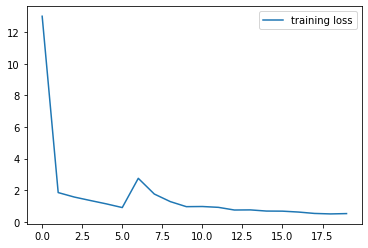

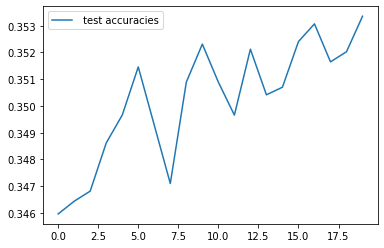

In [8]:
plt.plot(range(total_epoches), loss_history, label = "training loss")
plt.legend()
plt.show()
#plt.plot(range(total_epoches), train_performance, label = " train accuracies")
plt.plot(range(total_epoches), test_performance, label = " test accuracies")
plt.legend()
plt.show()

In [9]:
torch.save(GCNmodel.state_dict(), "model.pth")
torch.save(NCNCpredictor.state_dict(), "predictor.pth")
total_params = sum(p.numel() for p in GCNmodel.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 55463548


In [10]:
gc.collect()
total_epoches = 20
In = features.shape[1]
Hidden = 2*features.shape[1]
Out = int(0.5*features.shape[1])
num_layers = 5
dropout = 0
batch_size = 500
num_edge = edges.shape[1]
num_batches = int(num_edge/batch_size)
device = "cuda"

GCN_saved = MyGCN(In, Hidden, Out, num_layers, dropout).to(device)
GCN_saved.load_state_dict(torch.load("model.pth"))
predictor_saved = NCNC(2*Out, dropout, batch_size = batch_size, device = device).to(device)
predictor_saved.load_state_dict(torch.load("predictor.pth"))


negative_samples_complete = negative_sampling(edge_index=edges, num_nodes=dataset[0].num_nodes, num_neg_samples=dataset[0].num_edges)
total_correct = 0

for idx in range(num_batches):
    batchPos = edges[:,idx*batch_size:(idx+1)*batch_size].to(device)
    batchNeg = negative_samples_complete[:,idx*batch_size:(idx+1)*batch_size].to(device)
    pos_pred, neg_pred = test(original_adjacent.to(device), features.to(device), [batchPos, batchNeg], GCN_saved, predictor_saved, device, batch_size)
    total_correct += (sum(pos_pred == 1) + sum(neg_pred == 0))
    
total = edges.shape[1] + negative_samples_complete.shape[1]
complete_performance = total_correct/total
print("accuracy on complete", complete_performance)

accuracy on complete tensor(0.9866)


In [11]:
print("Total memory:", torch.cuda.get_device_properties('cuda').total_memory)
print("Allocated memory:", torch.cuda.memory_allocated('cuda'))
print("Cached memory:", torch.cuda.memory_reserved('cuda'))

Total memory: 11714887680
Allocated memory: 2569463808
Cached memory: 6366953472


In [5]:
from NCNC_test import NCNC2

# another try using random walk
nxGraph_input = to_networkx(removed_dataset[0], to_undirected = True)


def training_version2(trainingedge, features, original_edge, trainingset, testingset, model, predictor, nxGraph_input, optimizer, criterion, total_epoches, batch_size, device):
    num_edge = trainingset.shape[1]
    num_nodes = features.shape[0]
    num_batch = int(num_edge/batch_size)
    pos_label = torch.ones(batch_size).to(device)
    neg_label = torch.zeros(batch_size).to(device)
    loss_history = []
    train_performance = []
    test_performance = []
    #adjacent = torch.sparse_coo_tensor(trainingedge, torch.ones(trainingedge.shape[1]).to(device), torch.Size([num_nodes, num_nodes])).to(device)
    adjacent = to_dense_adj(trainingedge, max_num_nodes = num_nodes)[0].to(device)
    negative_samples = negative_sampling(edge_index=original_edge, num_nodes=num_nodes, num_neg_samples=2*num_edge)
    training_neg_samples = negative_samples[:,:num_edge]
    testing_neg_samples = negative_samples[:,num_edge:]    
    #nxGraph = to_networkx(trainingedge)

    
    for epoch in range(total_epoches):
        model.train()
        predictor.train()
        total_loss = 0
        start_time = time.time()
        total_loss = 0
        
        # shuffle dataset
        shuffled_idx = torch.randperm(num_edge, device = device)
        shuffled_dataset = trainingset[:,shuffled_idx]
        
        for idx in range(num_batch):
            print("batch", idx)
            optimizer.zero_grad()
            targetLink = shuffled_dataset[:,idx*batch_size:(idx+1)*batch_size].to(device)

            adjacent_hat = TargetLinkRemoval(trainingedge, targetLink, device)
            embedding = model(adjacent_hat, features)
            edge_pred = predictor(targetLink, adjacent, embedding, nxGraph_input)
            targetLink = training_neg_samples[:,idx*batch_size:(idx+1)*batch_size]
            neg_edge_pred = predictor(targetLink, adjacent, embedding, nxGraph_input)
            edge_pred = edge_pred.squeeze()
            neg_edge_pred = neg_edge_pred.squeeze()

            pos_loss = criterion(edge_pred, pos_label)
            neg_loss = criterion(neg_edge_pred, neg_label)
            loss = pos_loss+neg_loss
            total_loss += loss.item()

            loss.backward() 
            optimizer.step() 

            del adjacent_hat
            del embedding
            del targetLink
            del edge_pred
            del neg_edge_pred
            del pos_loss
            del neg_loss
            del loss
            torch.cuda.empty_cache()
            gc.collect()
        
        end_time = time.time()
        print(f'Epoch {epoch+1}/{epoch}, Loss: {total_loss}, time: {end_time-start_time}')
        loss_history.append(total_loss)
        
    return loss_history


torch.autograd.set_detect_anomaly(True)
total_epoches = 20
In = features.shape[1]
Hidden = 2*features.shape[1]
Out = int(0.5*features.shape[1])
num_layers = 5
dropout = 0
lr = 0.0001
batch_size = 500
weight_decay=1e-2
device = "cuda"

criterion = nn.BCEWithLogitsLoss()
GCNmodel2 = MyGCN(In, Hidden, Out, num_layers, dropout).to(device)

NCNCpredictor2 = NCNC2(2*Out, dropout, batch_size = batch_size, device = device)
optimizer = torch.optim.Adam(list(GCNmodel2.parameters()) + list(NCNCpredictor2.parameters()), lr=lr) #, weight_decay=weight_decay)

loss_history, train_performance, test_performance = training_version2(training_edges, features, edges, positive_samples, secondhalf_pos_dataset,
                                             GCNmodel2, NCNCpredictor2, nxGraph_input, optimizer, criterion, total_epoches, batch_size, device)



batch 0


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [716]], which is output 0 of ProdBackward1, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!